In [1]:
#Load relevant packages
using DelimitedFiles
using Printf
using Statistics
using PyPlot
using LinearAlgebra
using Random
using JuMP
using Ipopt

In [2]:
function load_stocks(dirname, startdate, enddate)
    
    "Function that reads stock price data over a given time period
    
    @param dirname: directory where data is stored
    @param startdate: startdate of interest
    @param enddate: end date of interest
    @return X: matrix where a column correponds to a given stock and each row the rate of return
    @return dates: an array of dates
    @return names: names of the stocks in X matrix"
    
    filenames = readdir(dirname)
    X = []
    dates = []
    names =  []
    
    for i = 1:length(filenames)
        file = filenames[i]
        data = readdlm( string( path, "/", file), ',')

        #add to names array
        push!(names, file[1:end-4])

        #get index of date column
        date_idx = findfirst(isequal("Date"), data[1,:])

        #get index of adj close column
        close_idx = findfirst(isequal("Close"), data[1,:])

        #get date index
        start_idx = findfirst(isequal(startdate),data[:,1])
        end_idx =  findfirst(isequal(enddate),data[:,1])

        #get relevant rows 
        adj_close = data[start_idx : end_idx, close_idx]
        dates = data[start_idx : end_idx, date_idx]

        #compute rate of return vector
        p1 = adj_close[1]
        rr = map(x -> (x-p1)/p1,adj_close )

        #append rate of return vector to X
        X = push!(X,rr)
    end
        
    return hcat(X...), dates, Array{String,1}(names)
end

load_stocks (generic function with 1 method)

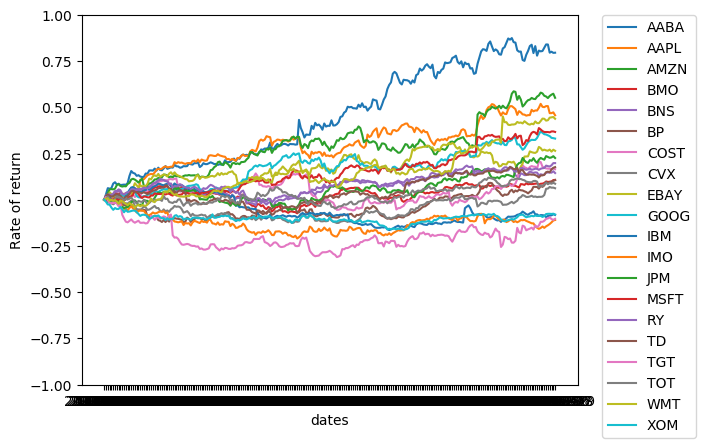

In [3]:
#plot of the stocks
include("preprocess.jl")
startdate = "2017-01-03"; enddate = "2017-12-29";
path = "data"
X,dates,names = load_stocks(path,startdate,enddate);
disp_stocks(X, dates, names)

In [4]:
#Getting mean rate of return and covariance matrix
function meancov(X)
    
    "Function that returns a vector of mean rate of return and the relevant covariance matrix
    
    @param X: X matrix, where each column is the rate of return from start day to next day
    @return r: vector of mean rate of return for each stock in X matrix
    @return Sig: Covariance matrix of rate of returns"
    
    r = mapslices(mean, X,dims=1)'
    Sig = cov(X)
    return Array{Float64,2}(r), Array{Float64,2}(Sig)
end

meancov (generic function with 1 method)

This below function must generate random portfolios and make a scatter plot
of their expected rates of return and standard deviation. Each random
portfolio is generated by randomly allocating a fraction of the
overall investment among a small set of 5 randomly chosen stocks. Make
a scatter plot with $num = 1000$ points.

In [5]:
function portfolio_scatter(r, Sig, num)
    
    "Plotting function. Gives var vs expected return for randomly generated portfolios
    
    @parm r: vector of mean rate of return for each stock in X matrix
    @param Sig: Covariance matrix of rate of returns
    @param num: number of times the simulation is ran"
    
    n = length(r)
    randmu = zeros(num)
    randSig = zeros(num)
    figure()
    
    for i=1:1num
        mu,sd = random_portfolio(r,Sig,n)
        randmu[i] = mu
        randSig[i] = sd
    end

    plot(randSig,randmu, "b+", markersize = 5)
    xlabel("Std. Dev.")
    ylabel("Expected Rate of Returen")

end


function random_portfolio(r,Sig,n)
    
    "Helper function that computes expected rate of return and sd of a random portfolio
    
    @param r: nx1 vector of mean rates of return of n stocks
    @param Sig: nxn covariance vector of n stocks
    @param n: the number of stocks in the orginal data"
    
    #Generate random indices
    indicies = collect(1:n)
    idx = indicies[randperm(n)]
    idx = idx[1:5]

    #Randomly allocate fraction of overall investment
    vals = rand(Float64,5)
    x = vals/sum(vals)
    
    #Compute exptected rate of return
    mu = r[idx]'*x
    
    #Compute sd
    sd = sqrt(x'*Sig[idx, idx]*x)
    
    return mu,sd
end

random_portfolio (generic function with 1 method)

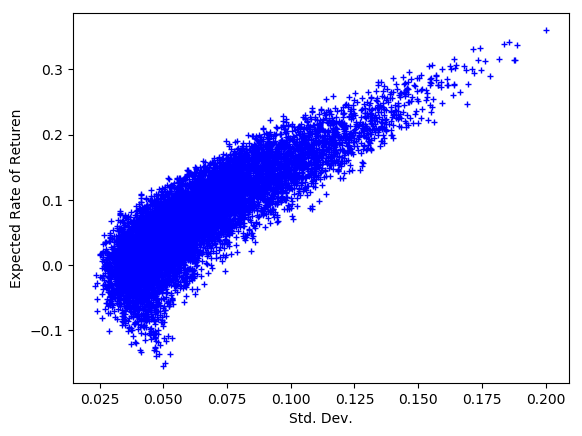

PyObject Text(24.00000000000002, 0.5, 'Expected Rate of Returen')

In [6]:
r,Sig = meancov(X)
portfolio_scatter(r,Sig,10000)

Here the protfolio with minimum risk is found. It is stated as a quadratic programming problem, with the constraints being no short-selling ($x \geq 0$) and that the sum of the x vector is one ($x^T \textbf{1}= 1$).


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Minimized risk is : 0.

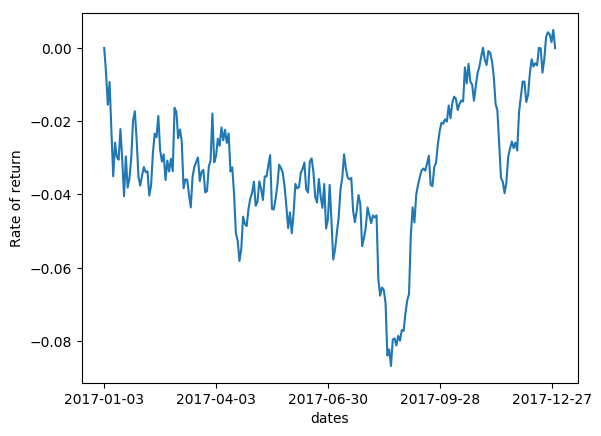

018359089295997905
Expected rate of return is: -0.03248147718110618

In [7]:
solver = IpoptSolver(print_level=0);
model = Model(solver=solver)
n = length(r)

#get minimized risk
@variable(model,xRi[1:n])
@objective(model,Min,xRi'*Sig*xRi);
@constraint(model,sum(xRi)==1);
@constraint(model, xRi.>=0);

solve(model);

min_risk = sqrt(getobjectivevalue(model))
portfolio = getvalue(xRi)
expected_rr = (r'*portfolio)[1];

print("Minimized risk is : " , min_risk, "\n")
print("Expected rate of return is: " , expected_rr)

#plot resulting rr
return_ts = X*portfolio;
plot(dates,return_ts)
xlabel("dates")
ylabel("Rate of return")
xticks(dates[1:div(end,4):end], dates[1:div(end,4):end]);

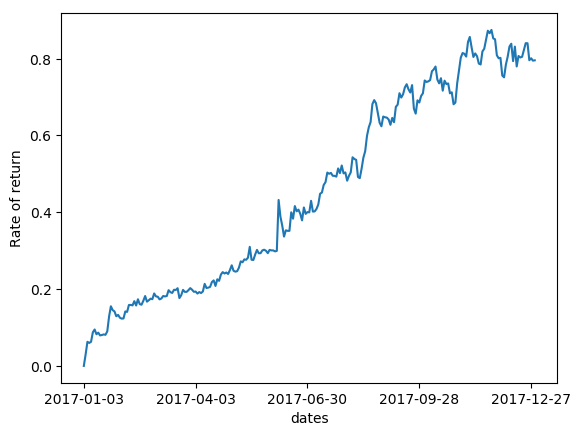

The maximized expected rate of return is: 0.45223215644743936


In [8]:
solver = IpoptSolver(print_level=0);
model2 = Model(solver=solver)
n = length(r)

@variable(model2,xRe[1:n])
@objective(model2,Max,dot(r,xRe))
@constraint(model2,sum(xRe) == 1)
@constraint(model2,xRe .>= 0)

solve(model2);
portfolio2 = getvalue(xRe)
rr_max = (r'*portfolio2)[1]

print("The maximized expected rate of return is: ", rr_max, '\n')

return_ts_max = X*portfolio2
plot(dates,return_ts_max)
xlabel("dates")
ylabel("Rate of return")
xticks(dates[1:div(end,4):end], dates[1:div(end,4):end]);

In [9]:

function return_range(r, Sig, num, startZero)
    
    "A function that returns _num_ linearly spaced rates of return between the portfolio with minimum risk
    and the one with maximum possible rate of return. 
    
    @param r: nx1 vector of rates of return 
    @param Sig: nxn covariance matrix
    @param num: The number of linearly spaced rates of returns wanted
    @param startZero: Boolean, if true array starts at zero
    @return rr_arr: An array of rates of returns"
    
    
    solver = IpoptSolver(print_level=0);
    model = Model(solver=solver)
    n = length(r)
    
    #get minimized risk
    @variable(model,x1[1:n])
    @objective(model,Min,x1'*Sig*x1);
    @constraint(model,sum(x1)==1);
    @constraint(model, x1.>=0);

    solve(model);

    min_risk = sqrt(getobjectivevalue(model))
    portfolio = getvalue(x1)
    expected_rr = (r'*portfolio)[1];
    
   
    
    #get max risk
    model2 = Model(solver=solver)

    @variable(model2,x2[1:n])
    @objective(model2,Max,dot(r,x2))
    @constraint(model2,sum(x2) == 1)
    @constraint(model2,x2 .>= 0)

    solve(model2);
    portfolio2 = getvalue(x2)
    rr_max = (r'*portfolio2)[1]
    
    if startZero == true
        expected_rr = 0
    end
        
    rr_arr = collect(range(expected_rr, stop = maximum(r) , length = num))
    
    return rr_arr
end

#test
rr = return_range(r,Sig,10,1)

10-element Array{Float64,1}:
 0.0                
 0.05024801427229637
 0.10049602854459273
 0.1507440428168891 
 0.20099205708918547
 0.25124007136148185
 0.3014880856337782 
 0.3517360999060746 
 0.40198411417837093
 0.4522321284506673 

In [10]:
function efficient_frontier(r, Sig, num,startZero )
    
    "Function that computes the efficent frontier for a given covariance matrix and return vector
    
    @param r: nx1 vector of rates of return  
    @param Sig: nxn covariance matrix
    @param num: The number of linearly spaced rates of returns wanted
    @param startZero: Boolean, if true array starts at zero
    
    @return Y: n x num matrix where each column is an efficent portfolio 
    @return rates: the average reate of return for each respective portfolio in Y
    @return sigs: the risk associated with each efficent portfolio
    "
 
    solver = IpoptSolver(print_level=0);
    model = Model(solver=solver)
    n = length(r)
    if startZero == true
        rrange = return_range(r, Sig, num,1)
        else 
        rrange = return_range(r, Sig, num,1)
    end
    
        
    
    Y = zeros(n, num)
    rates = zeros(num,1)
    sigs = zeros(num,1)
    
    for i = 1:num
        return_rate = rrange[i]
         #get minimized risk
        x = @variable(model,[i=1:n])
        @objective(model,Min,x'*Sig*x);
        @constraint(model,sum(x)==1);
        @constraint(model, x.>=0);
        @constraint(model,dot(x,r)>= return_rate)

        solve(model);

        min_risk = sqrt(getobjectivevalue(model))
        portfolio = getvalue(x)
        expected_rr = (r'*portfolio)[1];
        
        #store x values
        Y[:,i] = portfolio
        rates[i] = expected_rr
        sigs[i] = min_risk
        x = nothing

    end
    
    return Y, rates, sigs
end

efficient_frontier (generic function with 1 method)

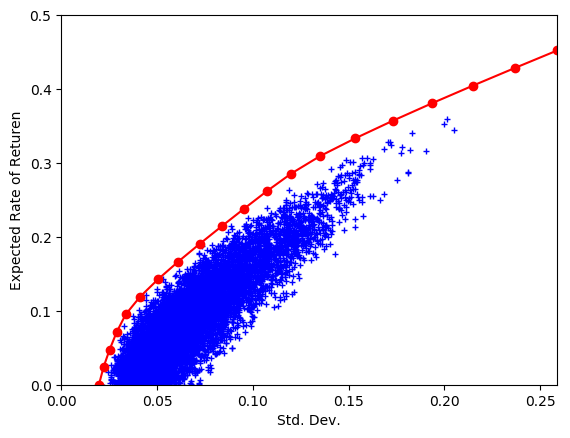

(0, 0.2588924050286056)

In [11]:
figure()
portfolio_scatter(r, Sig, 10000)
num = 20
Y, rates, sigs = efficient_frontier(r, Sig, num,1);
plot(sigs, rates, "ro-"); 
ylim(0, 0.5)
xlim(0, maximum(sigs))

Below are an assortment of portfolios with different levels of risk and expected rates of returns:

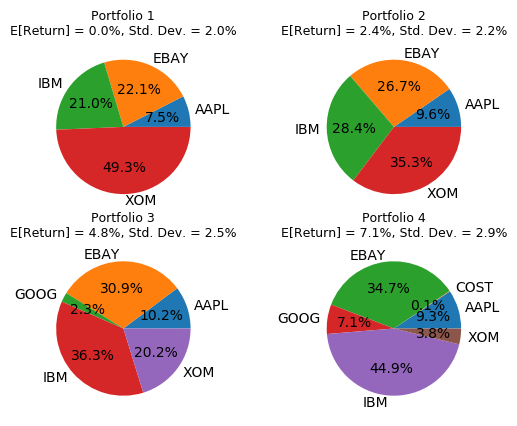

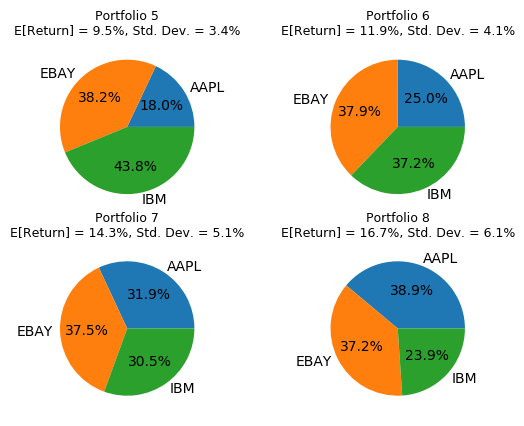

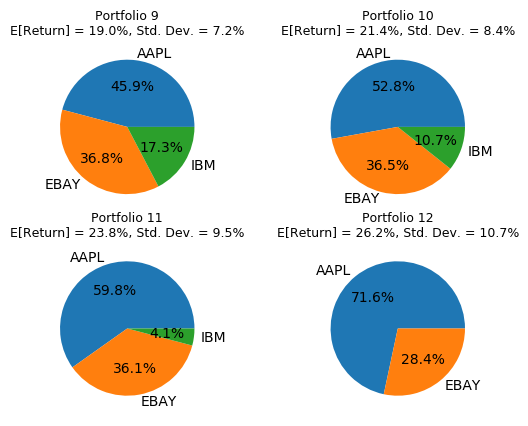

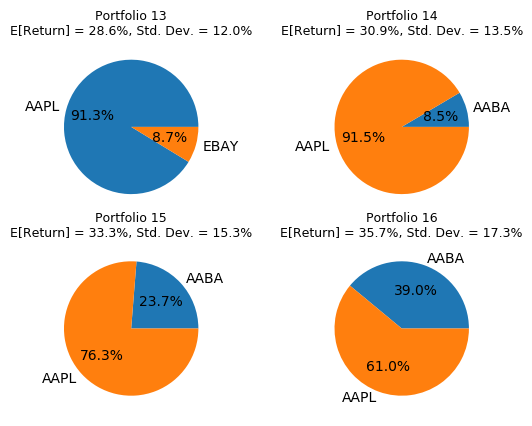

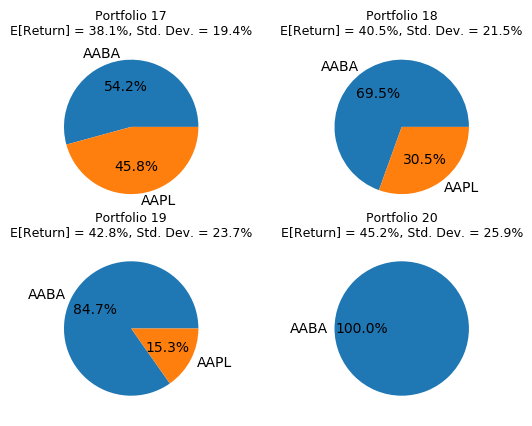


   Portfolio      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20
--------------------------------------------------------------------------------------------------------------------------------------------------------
     1  AABA    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.5   23.7   39.0   54.2   69.5   84.7  100.0
     2  AAPL    7.5    9.6   10.2    9.3   18.0   25.0   31.9   38.9   45.9   52.8   59.8   71.6   91.3   91.5   76.3   61.0   45.8   30.5   15.3   -0.0
     3  AMZN    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   -0.0
     4   BMO    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   -0.0
     5   BNS    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

In [13]:
include("preprocess.jl")
disp_portfolios(Y, rates, sigs, names)